<a href="https://colab.research.google.com/github/mimaimarima/DIODE_outdoor_with_MiDaS/blob/main/Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Додаток 1: „DIODE outdoor Depth Estimation with MiDaS"
Дипломски труд на тема „Мерење на растојание во слика"
Област: Дигитално процесирање на слика

Ментор: Доц. Д-р. Бојана Величковска
Студент: Мима Војновска со индекс 132/2021

Факултетот за електротехника и информациски технологии (ФЕИТ) при Универзитетот „Св. Кирил и Методиј“ во Скопје
Јуни 2025

Опис:
Оваа скрипта е за статистичка анализа на податоци и засебна анализа на примероци. Направена е засебно од анализата на целиот модел поради ограничувањата на runtime на Colab.
"""

'\nДодаток 1: „DIODE outdoor Depth Estimation with MiDaS"\nДипломски труд на тема „Мерење на растојание во слика"\nОбласт: Дигитално процесирање на слика\n\nМентор: Доц. Д-р. Бојана Величковска\nСтудент: Мима Војновска со индекс 132/2021\n\nФакултетот за електротехника и информациски технологии (ФЕИТ) при Универзитетот „Св. Кирил и Методиј“ во Скопје\nЈуни 2025\n\nОпис:\nОваа скрипта е за статистичка анализа на податоци и засебна анализа на примероци. Направена е засебно од анализата на целиот модел поради ограничувањата на runtime на Colab.\n'

Available Metrics Summary:


,AbsRel,RMSE,MAE,a1
count,498.000000,498.000000,498.000000,498.000000
mean,0.367704,6.563742,3.863952,0.676144
std,0.338077,5.062572,2.924934,0.214861
min,0.022953,0.288606,0.145487,0.113479
25%,0.149901,2.841112,1.685854,0.522994
50%,0.273786,5.503725,3.139810,0.706785
75%,0.459163,8.977960,5.324649,0.865540
max,2.289469,42.585651,23.370165,1.000000


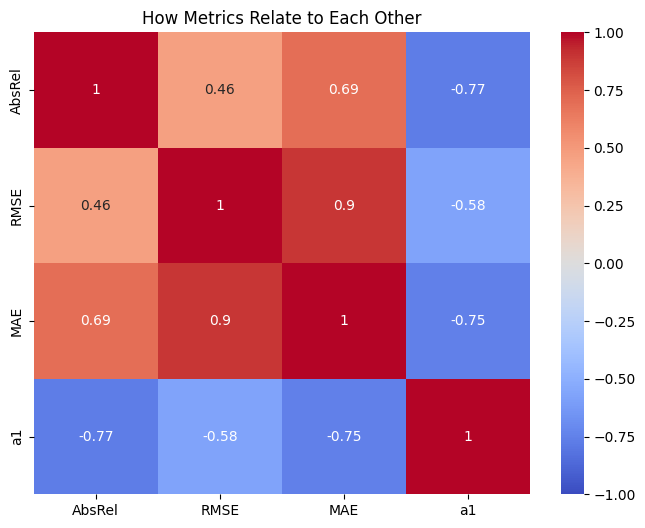

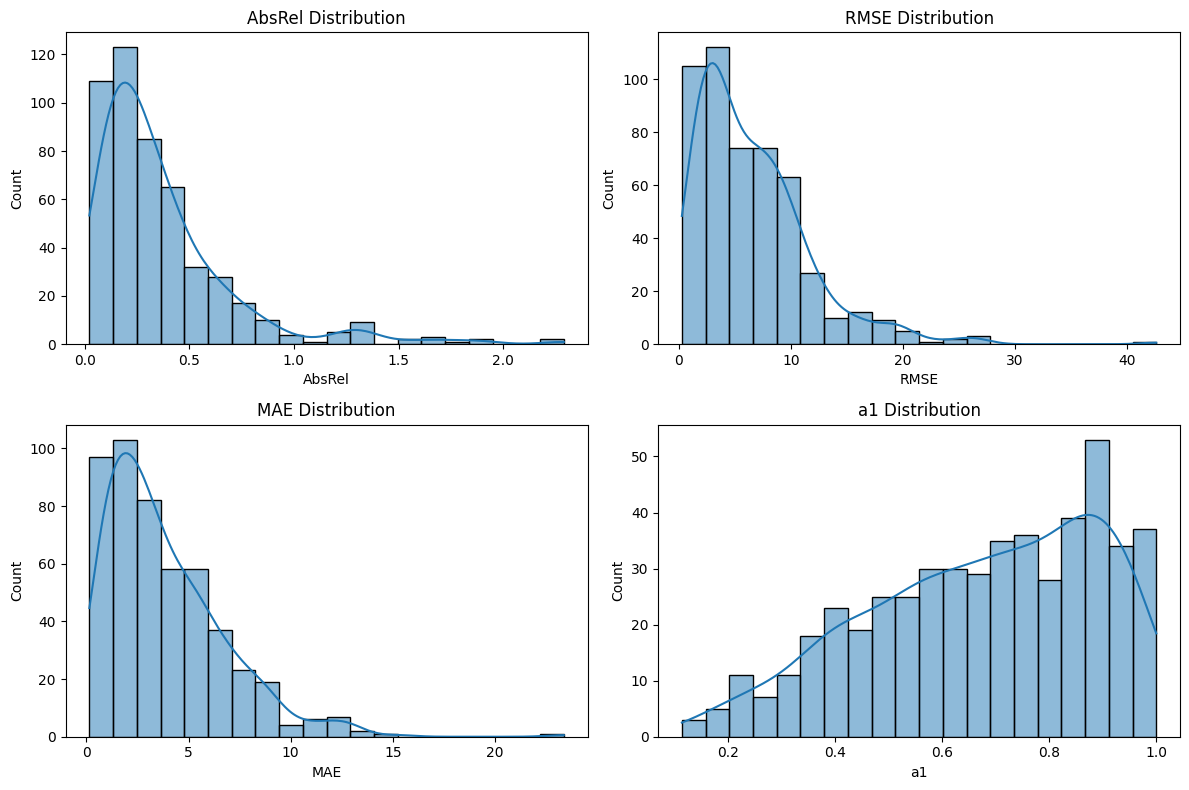


 Problem Cases Identified:


,count
Problem_Type,
Normal,402
High Relative Error,50
High Absolute Error,37
Low Accuracy,11


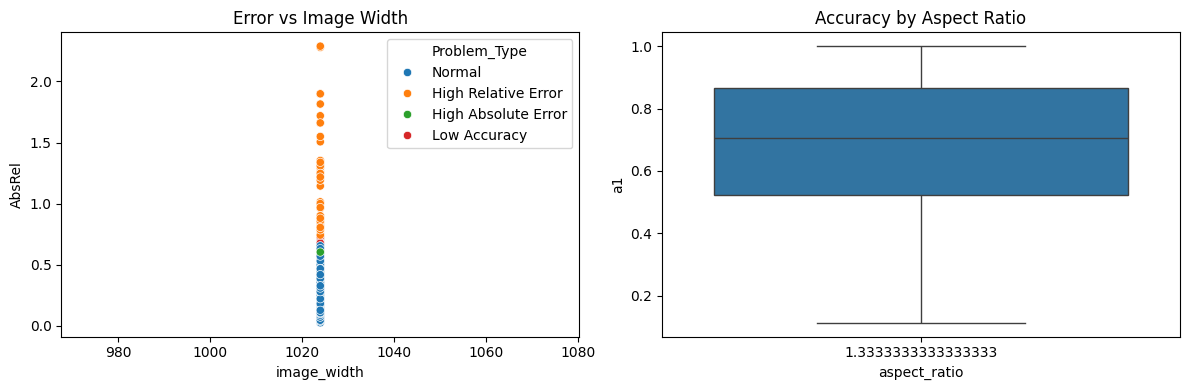


Saved 98 problem cases to 'problem_cases.csv'

Quick Recommendations:
- Investigate 50 high relative error cases (likely occlusion)
- Check 37 high RMSE cases (scale issues)
- Review 11 low-accuracy samples (textureless areas?)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cv2
import numpy as np

## Вчитување на податоци
df = pd.read_csv("midas_diode_results.csv")

## Основна статистика
print("Available Metrics Summary:")
display(df[['AbsRel', 'RMSE', 'MAE', 'a1']].describe())

## Корелација на метрики
plt.figure(figsize=(8,6))
sns.heatmap(df[['AbsRel', 'RMSE', 'MAE', 'a1']].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("How Metrics Relate to Each Other")
plt.show()

## Дистрибуција на грешка
fig, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, col in zip(axes.flatten(), ['AbsRel', 'RMSE', 'MAE', 'a1']):
    sns.histplot(df[col], bins=20, kde=True, ax=ax)
    ax.set_title(f"{col} Distribution")
plt.tight_layout()
plt.show()

## Категоризација на грешки
def flag_problems(row):
    if row['AbsRel'] > df['AbsRel'].quantile(0.9):
        return "High Relative Error"
    elif row['RMSE'] > df['RMSE'].quantile(0.9):
        return "High Absolute Error"
    elif row['a1'] < df['a1'].quantile(0.1):
        return "Low Accuracy"
    else:
        return "Normal"

df['Problem_Type'] = df.apply(flag_problems, axis=1)

## Идентификација на проблеми
print("\n Problem Cases Identified:")
problem_counts = df['Problem_Type'].value_counts()
display(problem_counts)


if all(col in df.columns for col in ['image_width', 'image_height']):
    df['aspect_ratio'] = df['image_width'] / df['image_height']

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    sns.scatterplot(data=df, x='image_width', y='AbsRel', hue='Problem_Type')
    plt.title("Error vs Image Width")

    plt.subplot(122)
    sns.boxplot(data=df, x='aspect_ratio', y='a1')
    plt.title("Accuracy by Aspect Ratio")
    plt.tight_layout()
    plt.show()


top_problems = df[df['Problem_Type'] != "Normal"].sort_values('AbsRel', ascending=False)
top_problems.to_csv("problem_cases.csv", index=False)
print(f"\nSaved {len(top_problems)} problem cases to 'problem_cases.csv'")

## Препораки
print("\nQuick Recommendations:")
if "High Relative Error" in problem_counts:
    print(f"- Investigate {problem_counts['High Relative Error']} high relative error cases (likely occlusion)")
if "High Absolute Error" in problem_counts:
    print(f"- Check {problem_counts['High Absolute Error']} high RMSE cases (scale issues)")
if "Low Accuracy" in problem_counts:
    print(f"- Review {problem_counts['Low Accuracy']} low-accuracy samples (textureless areas?)")

In [5]:
!pip install -q imageio torchsummary gdown
!pip install -q torch torchvision matplotlib opencv-python
!pip install timm

import os
import shutil

def setup_diode_dataset():
    try:
        !wget -q https://diode-dataset.s3.amazonaws.com/val.tar.gz
        !tar -xzf val.tar.gz
        !mkdir -p diode_dataset/train
        !mv val diode_dataset/train/outdoor
        return "/content/diode_dataset/train"


    except Exception as e:
        print(f"Could not download dataset: {e}")
        return None

DIODE_PATH = setup_diode_dataset()

if DIODE_PATH and os.path.exists(DIODE_PATH):
    print(f"Dataset ready at: {DIODE_PATH}")
    !ls {DIODE_PATH}
else:
    raise RuntimeError("Could not load the dataset. Please check your internet connection.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.3 MB/s eta 0:00:00
Dataset ready at: /content/diode_dataset/train
outdoor


In [6]:
## Процесирање на примерок

def process_sample(sample, model, transform, device):

    try:
        img = cv2.imread(sample['rgb'])
        if img is None:
            raise ValueError(f"Failed to load image: {sample['rgb']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        depth = np.load(sample['depth']).squeeze()
        mask = np.load(sample['mask']).squeeze()
        if img.shape[:2] != depth.shape or img.shape[:2] != mask.shape:
            raise ValueError("Shape mismatch between image/depth/mask")

        prediction = midas_prediction(img, model, transform, device)
        if prediction is None:
            return None

        pred_depth = prediction.copy()

        valid_mask = (depth > 0) & (mask > 0)
        if np.sum(valid_mask) > 100:  ## Проверка на минимален број валидни пиксели во маската (min = 100)

            ## Скалирање по медијана
            gt_median = np.median(depth[valid_mask])
            pred_median = np.median(pred_depth[valid_mask])

            ## IQR скалирање
            gt_iqr = np.percentile(depth[valid_mask], 75) - np.percentile(depth[valid_mask], 25)
            pred_iqr = np.percentile(pred_depth[valid_mask], 75) - np.percentile(pred_depth[valid_mask], 25)

            ## Комбиниран фактор на скалирање
            scale_factor = (gt_median/pred_median) * (gt_iqr/pred_iqr)
            pred_depth = pred_depth * scale_factor

        return {
            'filename': os.path.basename(sample['rgb']),
            'image': img,
            'true_depth': depth,
            'pred_depth': pred_depth,
            'mask': mask
        }
    except Exception as e:
        print(f"Error processing {sample.get('rgb', 'unknown')}: {str(e)}")
        return None

In [7]:
## Скалирање и поместување на длабочинските мапи

def scale_and_shift_align(pred, gt, mask):
    np.random.seed(42)
    pred = pred.reshape(gt.shape)
    pred_masked = pred[mask].flatten()
    gt_masked = gt[mask].flatten()

    ## Отстранување на outliers

    gt_median = np.median(gt_masked[gt_masked > 0])
    gt_mad = 1.4826 * np.median(np.abs(gt_masked[gt_masked > 0] - gt_median))

    valid = (gt_masked > 0) & (gt_masked < gt_median + 3*gt_mad) & \
            (pred_masked > 0) & (pred_masked < np.percentile(pred_masked, 95)) & \
            (~np.isnan(pred_masked)) & (~np.isinf(pred_masked))

    if np.sum(valid) < 50:
        return pred

    try:
        ## Линеарно усогласување
        A_linear = np.vstack([pred_masked[valid], np.ones_like(pred_masked[valid])]).T
        b_linear = gt_masked[valid]
        scale_linear, shift_linear = np.linalg.lstsq(A_linear, b_linear, rcond=None)[0]
        aligned_linear = scale_linear * pred + shift_linear

        ## Усогласување во логаритамски простор
        log_pred = np.log(pred_masked[valid] + 1e-6)
        log_gt = np.log(gt_masked[valid] + 1e-6)
        A_log = np.vstack([log_pred, np.ones_like(log_pred)]).T
        b_log = log_gt
        scale_log, shift_log = np.linalg.lstsq(A_log, b_log, rcond=None)[0]
        aligned_log = np.exp(shift_log) * (pred ** scale_log)

        ## Избор на подобро усогласување спрема RMSE
        rmse_linear = np.sqrt(np.mean((aligned_linear[mask][valid] - gt_masked[valid])**2))
        rmse_log = np.sqrt(np.mean((aligned_log[mask][valid] - gt_masked[valid])**2))

        return aligned_linear if rmse_linear < rmse_log else aligned_log
    except:
        return pred


In [8]:
## Визуелизација на резултати

def visualize_comparison(result, aligned_pred=None):

    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    ## RGB Слика
    axs[0].imshow(result['image'])
    axs[0].set_title('RGB Image')
    axs[0].axis('off')

    ## Вистинска длабочинска мапа
    gt_depth = np.ma.masked_where(result['mask'] == 0, result['true_depth'])
    gt_vmax = np.percentile(result['true_depth'][result['mask'] > 0], 99.5)
    im = axs[1].imshow(gt_depth, cmap='plasma', vmin=0, vmax=gt_vmax)
    axs[1].set_title('Ground Truth Depth')
    axs[1].axis('off')
    plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    ## Предвидување од MiDaS
    pred = np.ma.masked_where(result['mask'] == 0, result['pred_depth'])
    pred_vmax = np.percentile(result['pred_depth'][result['mask'] > 0], 99.5)
    im = axs[2].imshow(pred, cmap='plasma', vmin=0, vmax=pred_vmax)
    axs[2].set_title('MiDaS Prediction')
    axs[2].axis('off')
    plt.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    ## Усогласено предвидување
    if aligned_pred is not None:
        aligned = np.ma.masked_where(result['mask'] == 0, aligned_pred)
        aligned_vmax = np.percentile(aligned_pred[result['mask'] > 0], 99.5)
        im = axs[3].imshow(aligned, cmap='plasma', vmin=0, vmax=aligned_vmax)
        axs[3].set_title('Aligned MiDaS Prediction')
        axs[3].axis('off')
        plt.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)

    plt.suptitle(result['filename'])
    plt.tight_layout()
    plt.show()

In [9]:
## Предвидување со MiDas - Референца 1

def midas_prediction(img, model, transform, device):
    try:
        input_tensor = transform(img).to(device)
        if input_tensor.ndim == 3:
            input_tensor = input_tensor.unsqueeze(0) ## Midas бара (1,C,H,W) batch тензор на влез

        with torch.no_grad():
            prediction = model(input_tensor)
            if isinstance(prediction, (list, tuple)):
                prediction = prediction[0]
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1) if prediction.ndim == 3 else prediction,
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False
            ).squeeze().cpu().numpy()
        return prediction
    except Exception as e:
        print(f"MiDaS processing failed: {str(e)}")
        return None


In [10]:
# Вчитување и процесирање на специфичен примерок

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def load_specific_sample(rgb_path):

    base_name = os.path.splitext(os.path.basename(rgb_path))[0]
    depth_path = rgb_path.replace('.png', '_depth.npy')
    mask_path = rgb_path.replace('.png', '_depth_mask.npy')

    if not all(os.path.exists(p) for p in [rgb_path, depth_path, mask_path]):
        raise FileNotFoundError(f"Required files missing for {rgb_path}")

    return {
        'rgb': rgb_path,
        'depth': depth_path,
        'mask': mask_path
    }
def visualize_specific_sample(rgb_path, midas, transform, device):

    sample = load_specific_sample(rgb_path)
    if sample is None:
        print(f"Failed to load sample: {rgb_path}")
        return

    result = process_sample(sample, midas, transform, device)
    if result is None:
        print(f"Failed to process sample: {rgb_path}")
        return

    aligned_pred = scale_and_shift_align(
        result['pred_depth'],
        result['true_depth'],
        result['mask'].astype(bool)
    )

    visualize_comparison(result, aligned_pred)


In [11]:
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large").to(DEVICE).eval()
transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

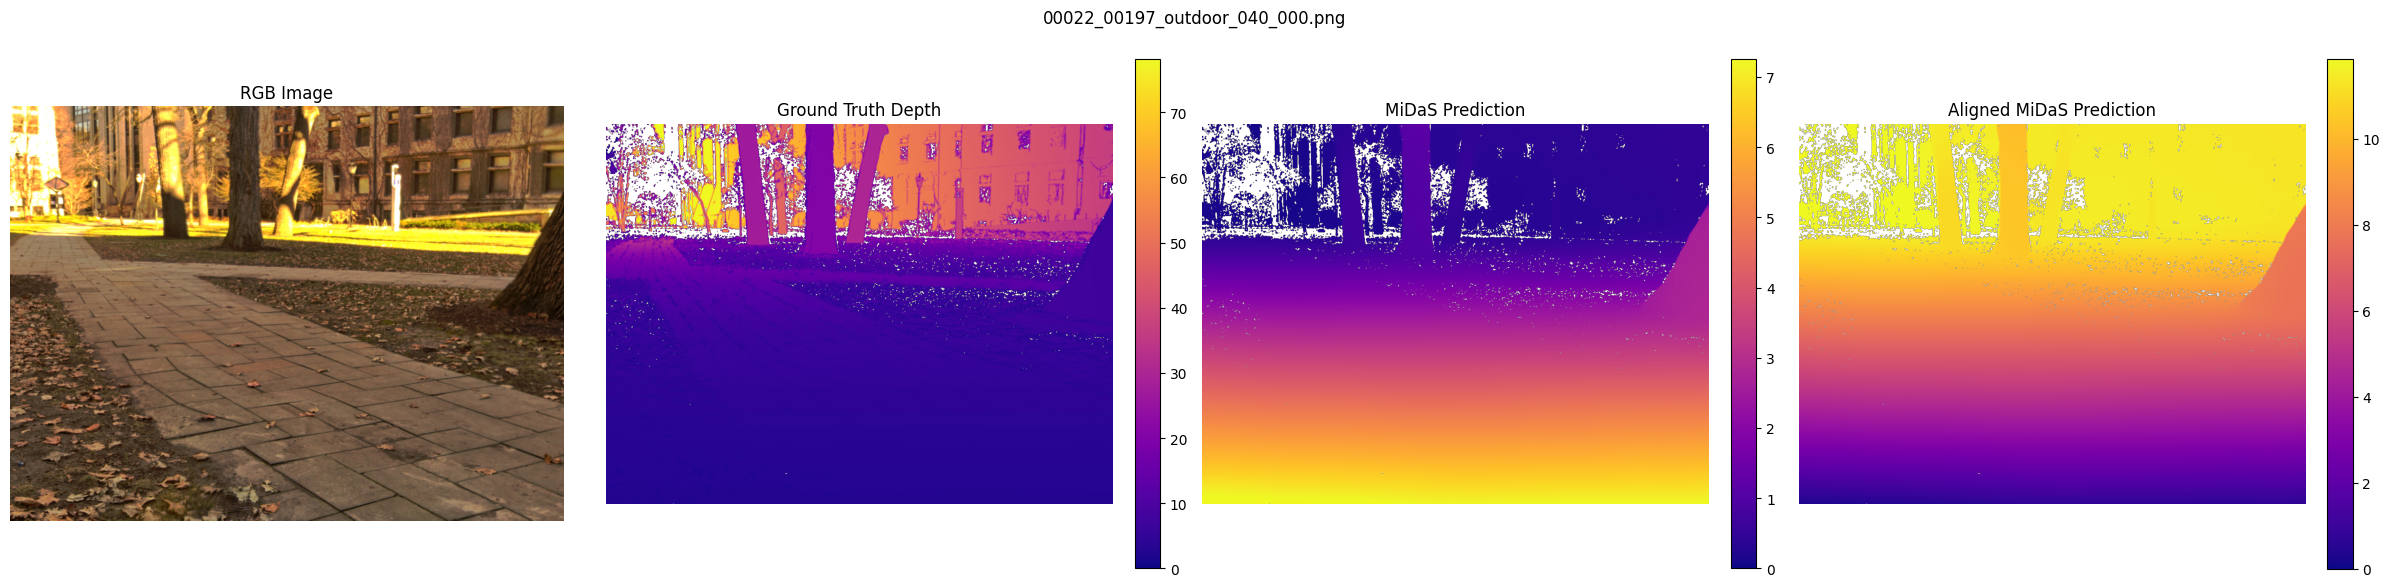

In [18]:
path = "/content/diode_dataset/train/outdoor/outdoor/scene_00022/scan_00197/00022_00197_outdoor_040_000.png"

visualize_specific_sample(path, midas, transform, DEVICE)



In [13]:
reference = {
    "author": "René Ranftl, Alexey Bochkovskiy, Vladlen Koltun",
    "title": "Vision Transformers for Dense Prediction",
    "journal": "CoRR",
    "volume": "abs/2103.13413",
    "year": 2021,
    "url": "https://arxiv.org/abs/2103.13413",
    "eprinttype": "arXiv",
    "eprint": "2103.13413"
}

# Референца 1